In [31]:
import json
import jiwer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [32]:
# Función auxiliar para asegurarse de que siempre se obtiene una lista de tokens
def safe_split(x):
    if isinstance(x, str):
        tokens = x.split()
        return tokens if tokens else ["<EMPTY>"]
    return x

# Función para calcular el Token Error Rate (Word Error Rate)
def compute_token_error_rate(reference, hypothesis):
    # Componer la transformación para normalizar ambos textos
    transformation = jiwer.Compose([
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords()
    ])
    # Calcula el Word Error Rate
    error_rate = jiwer.wer(
        reference, 
        hypothesis, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    return error_rate

# Función para calcular el BLEU
def compute_bleu(reference, hypothesis):
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)
    return bleu_score

# Función para calcular ROUGE-L
def compute_rouge(reference, hypothesis):
    rouge_evaluator = Rouge()
    scores = rouge_evaluator.get_scores(hypothesis, reference)
    rouge_l = scores[0]['rouge-l']['f']
    return rouge_l

# Función para calcular las métricas para cada respuesta
def calculate_metrics(results):
    for result in results:
        expected = result["expected_answer"].strip()
        generated = result["generated_answer"].strip()
        
        result["token_error_rate"] = compute_token_error_rate(expected, generated)
        result["bleu_score"] = compute_bleu(expected, generated)
        try:
            result["rouge_l"] = compute_rouge(expected, generated)
        except Exception as e:
            result["rouge_l"] = None
            print(f"Error al calcular ROUGE: {e}")
    return results

In [33]:
# Abrir los archivos JSON con los resultados
with open("non_expert_results.json", "r", encoding="utf-8") as f:
    non_expert_results = json.load(f)

with open("expert_results.json", "r", encoding="utf-8") as f:
    expert_results = json.load(f)

In [34]:
# Calcular métricas para cada conjunto
non_expert_results = calculate_metrics(non_expert_results)
expert_results = calculate_metrics(expert_results)

In [35]:
# Imprimir resultados para verificación
print("Resultados para preguntas no expertas con métricas:")
for res in non_expert_results:
    print(res)
    
print("\nResultados para preguntas expertas con métricas:")
for res in expert_results:
    print(res)

Resultados para preguntas no expertas con métricas:
{'question': '¿Qué son los riesgos ESG?', 'expected_answer': 'Son aquellos riesgos relacionados con factores ambientales, sociales y de gobernanza que pueden afectar la estabilidad y funcionamiento de las instituciones financieras, incluyendo riesgos derivados de la transición hacia economías sostenibles y riesgos físicos (como eventos climáticos extremos).', 'generated_answer': 'Los riesgos ESG se refieren a los riesgos ambientales, sociales y de gobernanza (Environmental, Social and Governance en inglés). Específicamente:\n\n- Riesgos ambientales: Relacionados con el cambio climático, la contaminación, la pérdida de biodiversidad, etc.\n\n- Riesgos sociales: Vinculados a cuestiones como derec', 'token_error_rate': 0.9210526315789473, 'bleu_score': 0.09716516292186668, 'rouge_l': 0.23529411268598627}
{'question': '¿Cuál es el objetivo principal de estas directrices ESG?', 'expected_answer': 'Establecer estándares mínimos y metodologí

In [36]:
# Guardar los resultados enriquecidos en nuevos archivos JSON
with open("non_expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(non_expert_results, f, ensure_ascii=False, indent=4)

with open("expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(expert_results, f, ensure_ascii=False, indent=4)


In [37]:
# Abrir los archivos JSON con los resultados
with open("non_expert_results_advanced.json", "r", encoding="utf-8") as f:
    non_expert_results_advanced = json.load(f)

with open("expert_results_advanced.json", "r", encoding="utf-8") as f:
    expert_results_advanced = json.load(f)


In [38]:
# Calcular métricas para cada conjunto
non_expert_results_advanced = calculate_metrics(non_expert_results_advanced)
expert_results_advanced = calculate_metrics(expert_results_advanced)
# Imprimir resultados para verificación
print("Resultados avanzados para preguntas no expertas con métricas:")
for res in non_expert_results_advanced:
    print(res)

print("\nResultados avanzados para preguntas expertas con métricas:")
for res in expert_results_advanced:
    print(res)


Resultados avanzados para preguntas no expertas con métricas:
{'question': '¿Qué son los riesgos ESG?', 'expected_answer': 'Son aquellos riesgos relacionados con factores ambientales, sociales y de gobernanza que pueden afectar la estabilidad y funcionamiento de las instituciones financieras, incluyendo riesgos derivados de la transición hacia economías sostenibles y riesgos físicos (como eventos climáticos extremos).', 'generated_answer': 'Los riesgos ESG son:\n\nRiesgos ambientales, sociales y de gobernanza.', 'token_error_rate': 0.8421052631578947, 'bleu_score': 0.01689071874072545, 'rouge_l': 0.29268292314098754}
{'question': '¿Cuál es el objetivo principal de estas directrices ESG?', 'expected_answer': 'Establecer estándares mínimos y metodologías de referencia para identificar, medir, gestionar y monitorizar los riesgos ESG en las instituciones.', 'generated_answer': 'El objetivo principal de estas directrices ESG es:\n\nGestionar riesgos ESG.', 'token_error_rate': 0.789473684210

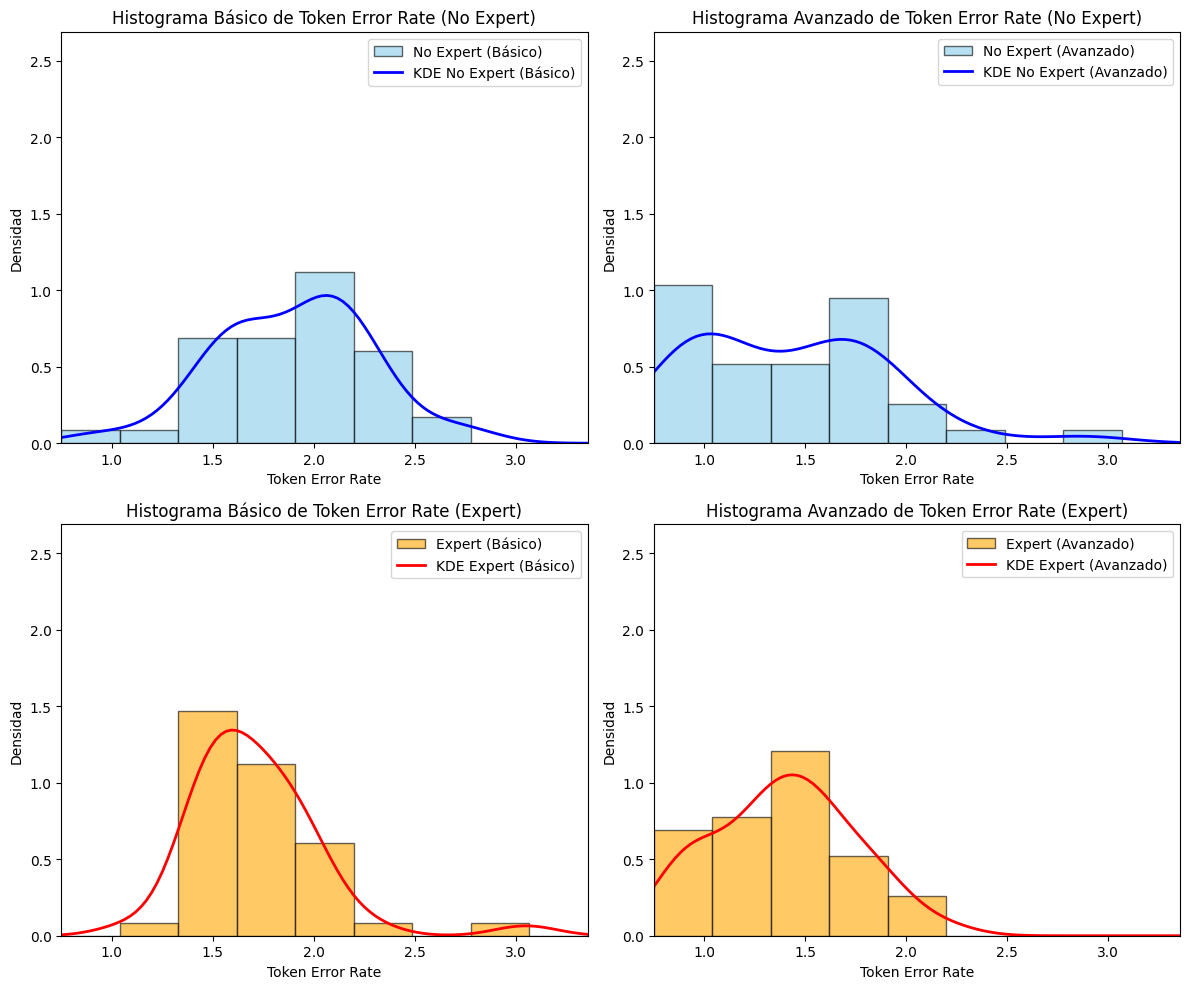

In [39]:
# Extraer token_error_rate para cada conjunto
non_expert_error_rates_basic    = [result['token_error_rate'] for result in non_expert_results]
expert_error_rates_basic        = [result['token_error_rate'] for result in expert_results]
non_expert_error_rates_advanced  = [result['token_error_rate'] for result in non_expert_results_advanced]
expert_error_rates_advanced      = [result['token_error_rate'] for result in expert_results_advanced]

# Calcular límites globales en el eje X a partir de todos los conjuntos
x_min = min(min(non_expert_error_rates_basic), min(expert_error_rates_basic),
            min(non_expert_error_rates_advanced), min(expert_error_rates_advanced))
x_max = max(max(non_expert_error_rates_basic), max(expert_error_rates_basic),
            max(non_expert_error_rates_advanced), max(expert_error_rates_advanced)) * 1.1

# Definir bins y dominio para las curvas KDE de forma global
bins = np.linspace(x_min, x_max, 11)
x_vals_global = np.linspace(x_min, x_max, 100)

# Calcular las curvas KDE para cada conjunto usando el dominio global
kde_basic_non_expert = gaussian_kde(non_expert_error_rates_basic)
y_basic_non_expert = kde_basic_non_expert(x_vals_global)

kde_adv_non_expert = gaussian_kde(non_expert_error_rates_advanced)
y_adv_non_expert = kde_adv_non_expert(x_vals_global)

kde_basic_expert = gaussian_kde(expert_error_rates_basic)
y_basic_expert = kde_basic_expert(x_vals_global)

kde_adv_expert = gaussian_kde(expert_error_rates_advanced)
y_adv_expert = kde_adv_expert(x_vals_global)

# Calcular el máximo global del eje Y a partir de las curvas KDE
global_y_max = max(y_basic_non_expert.max(), y_adv_non_expert.max(),
                   y_basic_expert.max(), y_adv_expert.max()) * 2  # margen del 10%

# Crear una figura con una cuadrícula de 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograma básico de preguntas no expertas (arriba izquierda)
ax = axes[0, 0]
ax.hist(non_expert_error_rates_basic, bins=bins, density=True, 
        alpha=0.6, color='skyblue', edgecolor='black', label='No Expert (Básico)')
ax.plot(x_vals_global, y_basic_non_expert, color='blue', linewidth=2, label='KDE No Expert (Básico)')
ax.set_title("Histograma Básico de Token Error Rate (No Expert)")
ax.set_xlabel("Token Error Rate")
ax.set_ylabel("Densidad")
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, global_y_max)
ax.legend()

# Histograma avanzado de preguntas no expertas (arriba derecha)
ax = axes[0, 1]
ax.hist(non_expert_error_rates_advanced, bins=bins, density=True, 
        alpha=0.6, color='skyblue', edgecolor='black', label='No Expert (Avanzado)')
ax.plot(x_vals_global, y_adv_non_expert, color='blue', linewidth=2, label='KDE No Expert (Avanzado)')
ax.set_title("Histograma Avanzado de Token Error Rate (No Expert)")
ax.set_xlabel("Token Error Rate")
ax.set_ylabel("Densidad")
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, global_y_max)
ax.legend()

# Histograma básico de preguntas expertas (abajo izquierda)
ax = axes[1, 0]
ax.hist(expert_error_rates_basic, bins=bins, density=True, 
        alpha=0.6, color='orange', edgecolor='black', label='Expert (Básico)')
ax.plot(x_vals_global, y_basic_expert, color='red', linewidth=2, label='KDE Expert (Básico)')
ax.set_title("Histograma Básico de Token Error Rate (Expert)")
ax.set_xlabel("Token Error Rate")
ax.set_ylabel("Densidad")
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, global_y_max)
ax.legend()

# Histograma avanzado de preguntas expertas (abajo derecha)
ax = axes[1, 1]
ax.hist(expert_error_rates_advanced, bins=bins, density=True, 
        alpha=0.6, color='orange', edgecolor='black', label='Expert (Avanzado)')
ax.plot(x_vals_global, y_adv_expert, color='red', linewidth=2, label='KDE Expert (Avanzado)')
ax.set_title("Histograma Avanzado de Token Error Rate (Expert)")
ax.set_xlabel("Token Error Rate")
ax.set_ylabel("Densidad")
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, global_y_max)
ax.legend()

plt.tight_layout()
plt.show()

In [40]:
# Guardar los resultados enriquecidos en nuevos archivos JSON
with open("non_expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(non_expert_results_advanced, f, ensure_ascii=False, indent=4)

with open("expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(expert_results_advanced, f, ensure_ascii=False, indent=4)